# Setup

In [19]:
# !pip uninstall httpx
!pip install --upgrade openai
!pip install httpx==0.27.2
!pip install langchain mistralai requests
!pip install langchain_openai google-search-results langchain
!pip install -U langchain-community
!pip install langchain-core
!pip install langchain_mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.1 MB/s eta 0:00:00
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32009 sha256=15efab5b2ab2a9901a78229acc8ee8db55e61189b160f77608b6b8b022819e88
  Stored in directory: /root/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371

In [20]:
import json
import os
import time
import re
import requests
import urllib.request
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate
from google.colab import userdata

import openai
from openai import OpenAI

In [224]:
openai_api_key = userdata.get('OPENAI_API_KEY')
mistral_api_key = userdata.get('MISTRAL_API_KEY')
rapidapi_key = userdata.get('RAPIDAPI_KEY')

print("API keys loaded successfully!")

client = openai.OpenAI(api_key=openai_api_key)

API keys loaded successfully!


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
def json_print(data):
    """Pretty print JSON data"""
    print(json.dumps(data, indent=2))

## Load and process data

In [ ]:
def load_json_data():
    """Load JSON data from remote URLs."""
    spec_url = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
    # data_url = "https://github.com/IBM/NESTFUL/raw/main/data/executable/executable-data.json"

    with urllib.request.urlopen(spec_url) as spec_resp:
        exec_spec = json.load(spec_resp)

    with urllib.request.urlopen(data_url) as data_resp:
        exec_data = json.load(data_resp)

    # Extract the first index as the test case
    exec_spec_0 = exec_spec[0]
    exec_data_0 = exec_data[0]

    print("Loaded JSON data and extracted the first index.")
    return exec_spec, exec_data, exec_spec_0, exec_data_0

In [ ]:
def convert_spec_to_dict(input_file, output_file):
    with open(input_file, 'r') as f:
        data = json.load(f)

    output_dict = {}
    for item in data:
        if 'name' not in item:
            print(f"Warning: Item missing 'name' field: {item}")
            continue

        name = item['name']
        if name in output_dict:
            raise ValueError(f"Error: Duplicate key '{name}' found in the JSON data.")
        output_dict[name] = item

    try:
        with open(output_file, 'w') as f:
            json.dump(output_dict, f, indent=2)
        print(f"Successfully converted JSON to dictionary and saved to '{output_file}'.")

    except Exception as e:
        print(f"Error saving to file: {e}")


input_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
output_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec-dict.json"

# convert_spec_to_dict(input_file_path, output_file_path)

In [ ]:
# Function to transform the data
input_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
output_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths-template.json"

def create_ground_truth_data(input_file, output_file):
    # Load the input JSON file
    with open(input_file, "r") as file:
        data = json.load(file)

    # Create a new transformed list
    transformed_data = []

    for obj in data:
        # Copy over the specified keys
        new_obj = {
            "name": obj.get("name", ""),
            "host": obj.get("host", ""),
            "url": obj.get("url", ""),
            "endpoint": obj.get("endpoint", ""),
            "query_parameters": {key: "" for key in obj.get("query_parameters", {}).keys()},
            "llm_query": ""
        }
        transformed_data.append(new_obj)

    # Save the transformed data back to a JSON file
    with open(output_file, "w") as outfile:
        json.dump(transformed_data, outfile, indent=4)

    print(f"Transformed data saved to: {output_file}")

# Run the function
# create_ground_truth_data(input_file_path, output_file_path)

## Experiment functions

#### make_api_call():
Used to execute the API command with our ground truth query parameters. This is only used for validation purposes to ensure that our ground truth parameters are valid.

In [ ]:
def make_api_call(query_string, api_url, host):
  # https://www.weatherapi.com/docs/#apis-s

  headers = {
    "x-rapidapi-key": rapidapi_key,
    "x-rapidapi-host": host
  }

  response = requests.get(api_url, headers=headers, params=query_string)
  print("host ", host, " response code ", response.status_code)
  return response.json(), response.status_code, query_string

In [ ]:
query_string = {"q":"London","days":"1","aqi":"yes"}
api_url = "https://weatherapi-com.p.rapidapi.com/forecast.json"
host = "weatherapi-com.p.rapidapi.com"
gt_test, gtp_code, gtp_test = make_api_call(query_string, api_url, host)

host  weatherapi-com.p.rapidapi.com  response code  200


#### make_llm_api_call()
Calls the LLM to generate the query parameters it thinks should be used for the API request given information from the user's query. The prompt used for the LLM differs based on whether we want to provide the LLM with a full query parameter schema, partial schema, or no schema.

In [219]:
def make_llm_api_call(api_name, api_url, query, llm_type, schema, naive=False):
  llm = None
  if llm_type == "mistral":
    llm = ChatMistralAI(
        model="mistral-large-latest",
        mistral_api_key=mistral_api_key,
        temperature=0,
        max_retries=2,
      )
  elif llm_type == "gpt-3.5":
    llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key)
  elif llm_type == "gpt-4o":
    llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)

  schema_info = ""
  if schema:
    required_keys = [k for k, v in schema["query_parameters"].items() if v["required"]]
    optional_keys = [k for k, v in schema["query_parameters"].items() if not v["required"]]

    schema_info = f"""These are a list of the required parameters {required_keys} and optional parameters {optional_keys}"""

    if naive:
      combined = required_keys + optional_keys
      print("Using naive schema with parameters ", combined)
      schema_info = f"""These are a list of the possible parameters {combined}"""

  schema_prompt = f"""
      Given the following api {api_url} and the query {query} to use to determine
      what parameters need to be set in the API call. {schema_info}.

      Return the parameters you would need to make this API call in a response as a dictionary of API query parameters. Ensure keys and values are proper strings.
      Do not include anything else such as comments (#).
      Only return this dictionary as your result and nothing else as I want to easily extract this object from your response.
      """
  prompt = ChatPromptTemplate.from_messages(
      [
      (
          "system",
          "You are a helpful assistant that creates an API call user request.",
      ),
      ("human", schema_prompt),
      ]
  )

  chain = prompt | llm
  result = chain.invoke(
      {
          "api": api_url,
          "query":query,
          # "schema": escaped_params,
      }
  )

  if result.content:
    print("DEBUG:", result.content)
    generated_params = result.content
    if '`' in generated_params:
      cleaned_response = result.content.strip('`').replace('json\n', '')
      print("DEBUG:", cleaned_response)
      try:
        # Attempt to parse JSON
        generated_params = json.loads(cleaned_response)
      except json.JSONDecodeError:
        print("Warning: LLM response is not valid JSON. Returning an empty dictionary.")
        generated_params = cleaned_response  # Fallback to an empty dictionary
  else:
    print("Error getting response!")
    return {"error": "Failed to generate API call"}

  return generated_params

#### evaluate_responses():

This is used to compare the LLM-generated query parameters with the ground truth parameters and provide an accuracy score based on how much they match. It calls out to an LLM to act as a "judge" of how accurate the LLM-generated parameters are.

This is used throughout the experiments, but its main use is when trying to evaluate LLM-generated query parameter responses where no schema is provided. This is because in the prompt, we can tell the evaluating/judge LLM to determine if two parameters should match even though their names might be different. We are not able to fully rely on a manually computed accuracy score since we'd need to account for all variations in parameter names among those whose purposes might match. (e.g. "departTime" and "leavingTime" correspond to the same parameter but their names do not match. We as the evaluator/judge LLM to infer their purpose and determine a match that way as opposed to doing an explicit equality check for strings)

In [209]:
# Evaluate responses
def evaluate_responses(ground_truth_params, generated_response_params, llm_type, use_schema):
    """Evaluate the responses using OpenAI GPT-3.5."""
    evaluator = None
    if llm_type == "mistral":
      evaluator = ChatMistralAI(
          model="mistral-large-latest",
          mistral_api_key=mistral_api_key,
          temperature=0,
          max_retries=2,
        )
    elif llm_type == "gpt-3.5":
      evaluator = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key)
    elif llm_type == "gpt-4o":
      evaluator = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)

    # Construct evaluation prompt
    if use_schema:
      eval_prompt = PromptTemplate(
          input_variables=["ground_truth_params", "generated_response_params"],
          template="""
          Compare the following two API query parameters and return the calculated accuracy score (using the calculation in the instructions) within brackets {{}} e.g. {{50.0%}} or {{100%}}:

          Ground Truth Response:
          {ground_truth_params}

          Generated Response:
          {generated_response_params}

          Instructions:
          - Check if the two responses are identical.
          - If identical, return a score of 100%.
          - If not, calculate the accuracy of the generated response as follows:
          -- accuracy = 100 - [100 * [0.7 * (# of parameters that exist in ground_truth_params but not generated_response_params / total # of parameters in ground_truth_params) +
                      0.3 * (# of parameters that exist in generated_response_params and not ground_truth_params / total # of parameters in ground_truth_params)]]
          - Return a summary score and justification.
          - You MUST return only the final accuracy score inside brackets {{}} regardless of what the score is, e.g. {{50.0}} or {{100}}
          """
      )
    else:
      eval_prompt = PromptTemplate(
        input_variables=["ground_truth_params", "generated_response_params"],
        template="""
        Compare the following two API query parameters and return a calculated accuracy score (using the calculation in the instructions) within brackets {{}} e.g. {{50.0%}} or {{100%}}:

        Ground Truth Response:
        {ground_truth_params}

        Generated Response:
        {generated_response_params}

        Instructions:
        - Note that the parameters might not have the same exact names, but if they seem like they refer to the same type or purpose, then you can consider them as a match.
          For example if we have two parameters called "departTime" and "leavingTime", we can assume that these both refer to the same purpose and so they should be treated as a match.
        - Check if the two responses seem identical, again keeping in mind that the naming schemes might not be the same, if the parameters seem related then they can be considered an identical pair.
        - If they seem identical, return a score of 100%.
        - If not, calculate the accuracy of the generated response as follows:
        -- accuracy = 100 - [100 * [0.7 * (# of parameters that exist in ground_truth_params but not generated_response_params / total # of parameters in ground_truth_params) +
                     0.3 * (# of parameters that exist in generated_response_params and not ground_truth_params / total # of parameters in ground_truth_params)]]
        - Return a summary score and justification.
        - You MUST return only the final accuracy score inside brackets {{}} regardless of what the score is, e.g. {{50.0}} or {{100}}
        """
    )

    chain = eval_prompt | evaluator

    result = chain.invoke({
        "ground_truth_params": ground_truth_params,
        "generated_response_params": generated_response_params,
    })

    return result.content

#### calculate_accuracy()

The computed accuracy score that is used as the "true" accuracy for experiments that involved the full or naive schema. In these experiments, this also helps us evaluate how well the LLM-as-a-judge can compute the accuraacy of the LLM-generated query parameters with the ground truth parameters.

In [8]:
def calculate_accuracy(ground_truth_params, generated_response_params):

  # Replace single quotes with double quotes
  if type(generated_response_params) == str:
      cleaned_response = generated_response_params.replace("'", '"')
      cleaned_generated_response_params = json.loads(cleaned_response)
  else:
      cleaned_generated_response_params = generated_response_params
  # Convert dictionaries into sets of keys
  ground_truth_keys = set(ground_truth_params.keys())
  generated_response_keys = set(cleaned_generated_response_params.keys())

  # Calculate missing parameters (in ground_truth but not in generated_response)
  missing_params = ground_truth_keys - generated_response_keys

  # Calculate extra parameters (in generated_response but not in ground_truth)
  extra_params = generated_response_keys - ground_truth_keys

  # Total parameters in ground_truth
  total_params = len(ground_truth_keys)

  # Avoid division by zero
  if total_params == 0:
      return 100.0

  # Calculate the accuracy using the formula
  accuracy = 100 - (100 *((0.7 * (len(missing_params) / total_params)) +
                    (0.3 * (len(extra_params) / total_params))))

  return accuracy

#### run_api_calls()
The runner code for the experiments. It calls the LLM to generate query parameters based on the user query (contained in the specs_dict) and calls the LLM-judge to determine accuracy using the ground truth parameters as well as the statically computed accuracy score.

In [226]:
ground_truths_file = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths.json"
specs_dict = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec-dict.json"

def run_api_calls(ground_truths_file, specs_dict, llm_type, use_schema, run_api=False, naive=False):

  llm_accuracies = []
  calc_accuracies = []
  qs_gen_eval_times = []
  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  with open(specs_dict, "r") as file:
    api_specs = json.load(file)

  api_responses = []
  llm_responses = []
  eval_times = []

  for obj in ground_truths:

    api_name = obj.get("name", "")

    query_str = obj.get("query_parameters", {})
    host = obj.get("host", "")
    endpoint = obj.get("endpoint", "")
    llm_query = obj.get("llm_query", "")

    api_url = "https://" + host + endpoint
    print("API: {}, Url: {}".format(api_name, api_url))

    # check that the query parameters are valid
    if run_api:
      resp, code, qs = make_api_call(query_str, api_url, host)
      api_responses.append(resp)

      if code != 200:
        print("API call failed for ", api_name, " , check the request.")
      if code == 200:
        print("API call succeeded -- ground truth query parameters are valid!")

    if api_name in api_specs:
        print("Found API spec!")

    print("Passing in LLM query: ", llm_query)

    if use_schema:
      spec = api_specs[api_name]
      start_time = time.time()
      generated_params = make_llm_api_call(api_name, api_url, llm_query, llm_type, spec, naive)
      end_time = time.time()
      eval_time = end_time - start_time
    else:
      print("Not using any schema")
      start_time = time.time()
      generated_params = make_llm_api_call(api_name, api_url, llm_query, llm_type, {})
      end_time = time.time()

    time.sleep(5)

    qs_gen_eval_time = end_time - start_time
    qs_gen_eval_times.append(qs_gen_eval_time)

    llm_responses.append(generated_params)

    print("Generated params: ", generated_params)
    print("Ground Truth params: ", query_str)

    scored_result = calculate_accuracy(query_str, generated_params)
    start_time = time.time()
    llm_eval_result = evaluate_responses(query_str, generated_params, llm_type, use_schema)
    end_time = time.time()
    eval_time = end_time - start_time
    eval_times.append(eval_time)
    print("Evaluation time: ", eval_time)

    print("LLM-as-a-judge accuracy score:", llm_eval_result)
    print("Function calculated accuracy score:", scored_result)

    # llm_accuracy = llm_eval_result.split("{{")[1].split("}}")[0]
    pattern = r"\{(.*?)\}"
    llm_accuracy = re.findall(pattern, llm_eval_result)
    print("DEBUG llm_accuracy", llm_accuracy)
    llm_accuracies.append(llm_accuracy)
    calc_accuracies.append(scored_result)

    time.sleep(5)

  llm_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_llm_eval_accuracies.json"
  calc_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_calc_accuracies.json"
  llm_resp_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_llm_responses.json"
  llm_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_eval_times.json"
  llm_qs_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_eval_times.json"

  if run_api:
    api_resp_outfile = "/content/drive/MyDrive/E6998-Project/results/" + llm_type + "_schema_" + str(use_schema)+  "_naive_" + str(naive)+ "_api_responses.json"
    with open(api_resp_outfile, "w") as outfile:
      json.dump(api_responses, outfile, indent=4)

  with open(llm_acc_outfile, "w") as outfile:
    json.dump(llm_accuracies, outfile, indent=4)

  with open(llm_resp_outfile, "w") as outfile:
    json.dump(llm_responses, outfile, indent=4)

  with open(calc_acc_outfile, "w") as outfile:
    json.dump(calc_accuracies, outfile, indent=4)

  with open(llm_eval_times_outfile, "w") as outfile:
    json.dump(eval_times, outfile, indent=4)

  with open(llm_qs_eval_times_outfile, "w") as outfile:
    json.dump(qs_gen_eval_times, outfile, indent=4)

  return llm_accuracies, calc_accuracies, llm_responses

#### compare_query_parameters()

Nearly identical to the above run_api_calls() except it does not execute the API command. It instead reads the LLM-generated results from a previously saved run and can be used to recompute or experiment with accuracy computations.

In [22]:
ground_truths_file = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths.json"
RESULTS_DIR = "results12172024"

def compare_query_parameters(ground_truths_file, llm_response_file, llm_type, use_schema):
  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  with open(llm_response_file, "r") as file:
    llm_responses = json.load(file)

  print(ground_truths)
  print(llm_responses)

  llm_accuracies = []
  calc_accuracies = []
  eval_times = []

  for idx, (gt_obj, llm_params) in enumerate(zip(ground_truths, llm_responses)):
    gt_params = gt_obj.get("query_parameters", {})

    print("Generated params: ", llm_params)
    print("Ground Truth params: ", gt_params)

    scored_result = calculate_accuracy(gt_params, llm_params)
    start_time = time.time()
    llm_eval_result = evaluate_responses(gt_params, llm_params, llm_type)
    end_time = time.time()
    eval_time = end_time - start_time
    eval_times.append(eval_time)
    print("Evaluation time: ", eval_time)

    print("LLM-as-a-judge accuracy score:", llm_eval_result)
    print("Function calculated accuracy score:", scored_result)

    pattern = r"\{(.*?)\}"
    llm_accuracy = re.findall(pattern, llm_eval_result)
    print("DEBUG llm_accuracy", llm_accuracy)
    llm_accuracies.append(llm_accuracy)
    calc_accuracies.append(scored_result)

    time.sleep(5)

  llm_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_llm_eval_accuracies.json"
  calc_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_calc_accuracies.json"
  llm_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_eval_times.json"

  with open(llm_acc_outfile, "w") as outfile:
    json.dump(llm_accuracies, outfile, indent=4)

  with open(calc_acc_outfile, "w") as outfile:
    json.dump(calc_accuracies, outfile, indent=4)

  with open(llm_eval_times_outfile, "w") as outfile:
    json.dump(eval_times, outfile, indent=4)

  return llm_accuracies, calc_accuracies, llm_responses


# Experiments

## Experiment 1: Mistral (with Spec)

---



In [ ]:
mistral_schema_true_llm_accuracies, mistral_schema_true_calc_accuracies, mistral_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "mistral", True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: ```json
{
  "q": "London",
  "days": "1",
  "aqi": "yes"
}
```
DEBUG: {
  "q": "London",
  "days": "1",
  "aqi": "yes"
}

Generated params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.6918566226959229
LLM-as-a-judge accuracy score: The two API query parameters are identical, so the accuracy score is 100% {100%}. This means that the generated response matches the ground truth response completely.
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100%']
API: Booking.com_Flights_API, Url: https://bookin

In [43]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/mistral_schema_True_llm_responses.json"
mistral_schema_true_llm_accuracies, mistral_schema_true_calc_accuracies, mistral_schema_true_llm_responses = compare_query_parameters(ground_truths_file, llm_response_file, "mistral", True)

[{'name': 'WeatherAPI.com_Forecast_Weather_API', 'host': 'weatherapi-com.p.rapidapi.com', 'url': 'https://rapidapi.com/weatherapi/api/weatherapi-com/playground/apiendpoint_02481648-7c41-48cc-9b9f-e53596d38bab', 'endpoint': '/forecast.json', 'query_parameters': {'q': 'London', 'days': '1', 'aqi': 'yes'}, 'llm_query': "What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality"}, {'name': 'Booking.com_Flights_API', 'host': 'booking-com15.p.rapidapi.com', 'url': 'https://booking-com15.p.rapidapi.com/api/v1/flights/searchFlights', 'endpoint': '/searchFlights.json', 'query_parameters': {'fromId': 'JFK.AIRPORT', 'toId': 'STO.AIRPORT', 'departDate': '2024-12-15', 'adults': '2', 'cabinClass': 'ECONOMY'}, 'llm_query': "I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I"}, {'name': 'SkyScrapperFlightSearch', 'host': 'sky-scrapper.p.rapidapi.com', 'url': 'https://rapidapi.com/api

## Experiment 2: Mistral (with naive Spec)



---




In [227]:
RESULTS_DIR = "results_naive12172024"

mistral_schema_false_llm_accuracies, mistral_schema_false_calc_accuracies, mistral_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "mistral", True, False, True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
Using naive schema with parameters  ['q', 'days', 'lang', 'dt', 'hour', 'aqi', 'tides']
DEBUG: {"q":"London","days":"1","aqi":"yes"}
Generated params:  {"q":"London","days":"1","aqi":"yes"}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.5304784774780273
LLM-as-a-judge accuracy score: {100}
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100']
API: Booking.com_Flights_API, Url: https://booking-com15.p.rapidapi.com/searchFlights.json
Found API spec!
Passing in LLM query:  I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I
Using naive schema with parameters  ['fromId', 'toId', 'departDate', 'returnDate', 'adults', 'children', 

## Experiment 3: Mistral (without Spec)



---




In [240]:
RESULTS_DIR = "results_noschema12172024"
mistral_schema_false_llm_accuracies, mistral_schema_false_calc_accuracies, mistral_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "mistral", False, False, False)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
Not using any schema
DEBUG: {"q":"London","days":"1","aqi":"yes"}
Generated params:  {"q":"London","days":"1","aqi":"yes"}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  5.665388107299805
LLM-as-a-judge accuracy score: To determine the accuracy score between the Ground Truth Response and the Generated Response, we need to follow the instructions provided.

### Step-by-Step Analysis:

1. **Identify Parameters:**
   - **Ground Truth Response:**
     ```json
     {'q': 'London', 'days': '1', 'aqi': 'yes'}
     ```
   - **Generated Response:**
     ```json
     {"q":"London","days":"1","aqi":"yes"}
     ```

2. **Check for Identical Parameters:**
   - Both responses have the same paramete

## Experiment 4: GPT 3.5 (with Spec)


---




In [ ]:
gpt3_5_schema_true_llm_accuracies, gpt3_5_schema_true_calc_accuracies, gpt3_5_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-3.5", True, False, False)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {
    "q": "London",
    "aqi": "yes"
}
Generated params:  {
    "q": "London",
    "aqi": "yes"
}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  1.562256097793579
LLM-as-a-judge accuracy score: The ground truth response has 3 parameters: {'q', 'days', 'aqi'}
The generated response has 2 parameters: {'q', 'aqi'}

Calculating the accuracy score:
accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (0/3)]]
accuracy = 100 - [100 * [0.7 * 0.333 + 0.3 * 0]]
accuracy = 100 - [100 * 0.233]
accuracy = 100 - 23.3
accuracy = 76.7%

Therefore, the accuracy score is {76.7%} as the

In [ ]:
gpt3_5_schema_true_llm_accuracies, gpt3_5_schema_true_calc_accuracies, gpt3_5_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-3.5", True, False, False)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {
    "q": "London",
    "aqi": "yes"
}
Generated params:  {
    "q": "London",
    "aqi": "yes"
}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  1.725449562072754
LLM-as-a-judge accuracy score: The ground truth response has 3 parameters: 'q', 'days', 'aqi'
The generated response has 2 parameters: 'q', 'aqi'

Calculating accuracy:
accuracy = 100 - [100 * [0.7 * (1 / 3) + 0.3 * (0 / 3)]]
accuracy = 100 - [100 * [0.7 * 0.333 + 0.3 * 0]]
accuracy = 100 - [100 * 0.233]
accuracy = 100 - 23.3
accuracy = 76.7

Therefore, the accuracy score is {76.7} as the generated r

In [44]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/gpt-3.5_schema_True_llm_responses2.json"
gpt3_5_schema_true_llm_accuracies, gpt3_5_schema_true_calc_accuracies, gpt3_5_schema_true_llm_responses = compare_query_parameters(ground_truths_file, llm_response_file, "gpt-3.5", True)

[{'name': 'WeatherAPI.com_Forecast_Weather_API', 'host': 'weatherapi-com.p.rapidapi.com', 'url': 'https://rapidapi.com/weatherapi/api/weatherapi-com/playground/apiendpoint_02481648-7c41-48cc-9b9f-e53596d38bab', 'endpoint': '/forecast.json', 'query_parameters': {'q': 'London', 'days': '1', 'aqi': 'yes'}, 'llm_query': "What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality"}, {'name': 'Booking.com_Flights_API', 'host': 'booking-com15.p.rapidapi.com', 'url': 'https://booking-com15.p.rapidapi.com/api/v1/flights/searchFlights', 'endpoint': '/searchFlights.json', 'query_parameters': {'fromId': 'JFK.AIRPORT', 'toId': 'STO.AIRPORT', 'departDate': '2024-12-15', 'adults': '2', 'cabinClass': 'ECONOMY'}, 'llm_query': "I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I"}, {'name': 'SkyScrapperFlightSearch', 'host': 'sky-scrapper.p.rapidapi.com', 'url': 'https://rapidapi.com/api

<ipython-input-7-78133edd7529>:13: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  evaluator = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key)


Evaluation time:  1.3661212921142578
LLM-as-a-judge accuracy score: The ground truth response has 3 parameters: {'q', 'days', 'aqi'}
The generated response has 2 parameters: {'q', 'aqi'}

Calculating accuracy:
accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (0/3)]
accuracy = 100 - [100 * (0.2333 + 0)]
accuracy = 100 - 23.33
accuracy = 76.67

Therefore, the accuracy score is {76.67}
Function calculated accuracy score: 76.66666666666667
DEBUG llm_accuracy ["'q', 'days', 'aqi'", "'q', 'aqi'", '76.67']
Generated params:  {
    "fromId": "NYCA",
    "toId": "STO",
    "departDate": "today"
}
Ground Truth params:  {'fromId': 'JFK.AIRPORT', 'toId': 'STO.AIRPORT', 'departDate': '2024-12-15', 'adults': '2', 'cabinClass': 'ECONOMY'}
Evaluation time:  1.9166250228881836
LLM-as-a-judge accuracy score: The ground truth response has 5 parameters:
- fromId: JFK.AIRPORT
- toId: STO.AIRPORT
- departDate: 2024-12-15
- adults: 2
- cabinClass: ECONOMY

The generated response has 3 parameters:
- fromId: NYCA


## Experiment 5: GPT 3.5 (with naive Spec)


---




In [197]:

RESULTS_DIR = "results_naive12172024"
gpt3_5_schema_false_llm_accuracies, gpt3_5_schema_false_calc_accuracies, gpt3_5_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-3.5", True, False, True)


API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
Using naive schema
DEBUG: {
    "q": "London",
    "aqi": "yes"
}
Generated params:  {
    "q": "London",
    "aqi": "yes"
}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  1.3399715423583984
LLM-as-a-judge accuracy score: The ground truth response has 3 parameters: 'q', 'days', 'aqi'
The generated response has 2 parameters: 'q', 'aqi'

Calculating the accuracy score:
accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (0/3)]]
accuracy = 100 - [100 * [0.7 * 0.33]]
accuracy = 100 - [100 * 0.231]
accuracy = 100 - 23.1
accuracy = 76.9

Therefore, the accuracy score is {76.9}
Function calculated accuracy score: 76.66666666666667
DEBUG llm_accuracy ['76.9']
API: Booking.com_Flights_API, Url: https

## Experiment 6: GPT 3.5 (without Spec)


---




In [211]:
RESULTS_DIR = "results_noschema12172024"
gpt3_5_schema_false_llm_accuracies, gpt3_5_schema_false_calc_accuracies, gpt3_5_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-3.5", False, False, False)


API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
Not using any schema
DEBUG: {
    "q": "London",
    "days": "1"
}
Generated params:  {
    "q": "London",
    "days": "1"
}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  1.7528407573699951
LLM-as-a-judge accuracy score: The ground truth response has 3 parameters: 'q', 'days', and 'aqi'.
The generated response has 2 parameters: 'q' and 'days'.

Calculating the accuracy score:
- Parameters in ground truth but not in generated response: 1 ('aqi')
- Parameters in generated response but not in ground truth: 0
- Total parameters in ground truth: 3

Accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (0/3)]]
Accuracy = 100 - [100 * [0.7 * 0.33 + 0]]
Accuracy = 100 - [100 * 0.231]
Accuracy = 100 -

## Experiment 7: GPT 4o (with Spec)


---




In [45]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/gpt-4o_schema_True_llm_responses.json"
gpt4_schema_true_llm_accuracies, gpt4_schema_true_calc_accuracies, gpt4_schema_true_llm_responses = compare_query_parameters(ground_truths_file, llm_response_file, "gpt-4o", True)

[{'name': 'WeatherAPI.com_Forecast_Weather_API', 'host': 'weatherapi-com.p.rapidapi.com', 'url': 'https://rapidapi.com/weatherapi/api/weatherapi-com/playground/apiendpoint_02481648-7c41-48cc-9b9f-e53596d38bab', 'endpoint': '/forecast.json', 'query_parameters': {'q': 'London', 'days': '1', 'aqi': 'yes'}, 'llm_query': "What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality"}, {'name': 'Booking.com_Flights_API', 'host': 'booking-com15.p.rapidapi.com', 'url': 'https://booking-com15.p.rapidapi.com/api/v1/flights/searchFlights', 'endpoint': '/searchFlights.json', 'query_parameters': {'fromId': 'JFK.AIRPORT', 'toId': 'STO.AIRPORT', 'departDate': '2024-12-15', 'adults': '2', 'cabinClass': 'ECONOMY'}, 'llm_query': "I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I"}, {'name': 'SkyScrapperFlightSearch', 'host': 'sky-scrapper.p.rapidapi.com', 'url': 'https://rapidapi.com/api

In [ ]:
gpt4_schema_true_llm_accuracies, gpt4_schema_true_calc_accuracies, gpt4_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-4o", True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {"q": "London", "days": "1", "aqi": "yes"}
Generated params:  {"q": "London", "days": "1", "aqi": "yes"}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.7784361839294434
LLM-as-a-judge accuracy score: The ground truth response and generated response have the same parameters, so the accuracy score is 100% {100%}.
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100%']
API: Booking.com_Flights_API, Url: https://booking-com15.p.rapidapi.com/searchFlights.json
host  booking-com15.p.rapidapi.com  response code  404
API call failed for  Booking.com_Fli

In [ ]:
gpt4_schema_true_llm_accuracies, gpt4_schema_true_calc_accuracies, gpt4_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-4o", True)

## Experiment 8: GPT 4o (with naive Spec)


---




In [198]:
RESULTS_DIR = "results_naive12172024"

gpt4_schema_false_llm_accuracies, gpt4_schema_false_calc_accuracies, gpt4_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-4o", True, False, True)


API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
Using naive schema
DEBUG: {"q": "London", "days": "1", "aqi": "yes"}
Generated params:  {"q": "London", "days": "1", "aqi": "yes"}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.8257029056549072
LLM-as-a-judge accuracy score: {100}
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100']
API: Booking.com_Flights_API, Url: https://booking-com15.p.rapidapi.com/searchFlights.json
Found API spec!
Passing in LLM query:  I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I
Using naive schema
DEBUG: {"fromId": "NYC", "toId": "STO", "departDate": "2023-10-10", "adults": "2", "currency_code": "USD"}
Generated params:  {"fromId": "NYC", "

## Experiment 9: GPT 4o (without Spec)


---




In [220]:
RESULTS_DIR = "results_noschema12172024"
gpt4_schema_false_llm_accuracies, gpt4_schema_false_calc_accuracies, gpt4_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-4o", False, False, False)


API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
Not using any schema
DEBUG: ```json
{
  "q": "London",
  "days": "1",
  "aqi": "yes"
}
```
DEBUG: {
  "q": "London",
  "days": "1",
  "aqi": "yes"
}

Generated params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.5757253170013428
LLM-as-a-judge accuracy score: {100}
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100']
API: Booking.com_Flights_API, Url: https://booking-com15.p.rapidapi.com/searchFlights.json
Found API spec!
Passing in LLM query:  I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I
Not using any schema
DEBUG: ```json
{
  "origin": "NYC",
  "destination": "STO",
  

# Results


---





In [24]:
ground_truths_file = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths.json"

In [1]:
def clean_scores(scores):
  cleaned_scores = []
  for item in scores:
    if '%' in item:
      cleaned = item.replace('%', '')
    else:
      cleaned = item

    cleaned_scores.append(float(cleaned))

  return cleaned_scores

In [34]:
##############################################################################
# Plots the LLM-as-a-judge and computed accuracy scores accross the 3
# model types
##############################################################################

def plot_scores(llm_type, use_schema, naive=False):
  llm_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_llm_eval_accuracies.json"
  calc_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_calc_accuracies.json"
  llm_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_eval_times.json"

  api_dict = {}

  with open(llm_acc_outfile, "r") as file:
    llm_acc = json.load(file)
    llm_eval_acc = [acc[0] for acc in llm_acc]

  with open(calc_acc_outfile, "r") as file:
    calc_acc = json.load(file)

  with open(llm_eval_times_outfile, "r") as file:
    eval_times = json.load(file)

  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  print(llm_eval_acc)
  print(calc_acc)
  print(eval_times)

  cleaned_llm_eval_acc = clean_scores(llm_eval_acc)

  df = pd.DataFrame({'LLM-as-a-judge accuracy': cleaned_llm_eval_acc, 'Computed accuracy': calc_acc, 'Judging eval Time': eval_times})

  x_range = list(range(0, len(df)))
  y_range = [-5, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 5))
  plt.tight_layout()

  # plt.scatter(llm_eval_acc)
  sns.scatterplot(x=df.index, y=df['Computed accuracy'], marker='o', s=100, label='Computed accuracy', color='C0')

  # Plot col2 with x marker and smaller size
  sns.scatterplot(x=df.index, y=df['LLM-as-a-judge accuracy'], marker='x', s=200, label='LLM-as-a-judge accuracy', color='red')

  plt.xticks(x_range)
  plt.yticks(y_range)
  plt.xlim(-1, len(calc_acc))
  plt.ylim(0, 105)
  # sns.lineplot(data=eval_times, x="Batch Size", y="Throughput", marker="o")
  plt.title(llm_type+ "-as-a-Judge Accuracy vs. Computed Accuracy")
  plt.xlabel("API Run #")
  plt.ylabel("Accuracies")
  plt.legend(loc='lower center')

  plt.show()

  return df


In [3]:
##############################################################################
# Calculates the % of matched scores between the LLM-as-a-judge accuracy and
# the computed accuracy between each model type.
##############################################################################

def calculate_match_percentage(df):
  """Calculates the percentage of times LLM and computed accuracy match."""
  return (df['LLM-as-a-judge accuracy'] == df['Computed accuracy']).mean() * 100

def calculate_precent_match(mistral_df, gpt3_df, gpt4_df):
  # Calculate percentages
  mistral_percentage = calculate_match_percentage(mistral_df)
  gpt3_5_percentage = calculate_match_percentage(gpt3_df)
  gpt4_percentage = calculate_match_percentage(gpt4_df)

  # Create a bar chart
  models = ['Mistral', 'GPT-3.5', 'GPT-4']
  percentages = [mistral_percentage, gpt3_5_percentage, gpt4_percentage]
  colors = ['skyblue', 'lightcoral', 'lightgreen']

  plt.figure(figsize=(8, 6))
  plt.bar(models, percentages, color=colors)
  plt.xlabel('LLM Model')
  plt.ylabel('Match Percentage (%)')
  plt.title('Percentage of Matching LLM-as-a-judge Accuracy and Computed Accuracy Scores')
  plt.ylim(0, 100) # Set y-axis limit

  for i, v in enumerate(percentages):
      plt.text(i, v + 2, str(round(v, 2)) + '%', ha='center') # Add percentage labels


  plt.show()

In [7]:
import warnings
warnings.filterwarnings("ignore")

##############################################################################
# Counts the number of ground truth optional and required parameters as well as
# the number of LLM-generated optional and required parameters for
# comparison
##############################################################################

def avg_acc_plot(mistral_df, gpt3_df, gpt4_df):

  dfs = [mistral_df, gpt3_df, gpt4_df]
  df_names = ['Mistral', 'GPT-3.5', 'GPT-4o']
  colors = ['skyblue', 'lightcoral', 'lightgreen']

  avg_computed_accuracy = [df['Computed accuracy'].mean() for df in dfs]
  rounded_avg_computed_accuracy = [round(num, 2) for num in avg_computed_accuracy]

  avg_llm_accuracy = [df['LLM-as-a-judge accuracy'].mean() for df in dfs]
  rounded_avg_llm_accuracy = [round(num, 2) for num in avg_llm_accuracy]

  y_range = [0, 5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  ax = sns.barplot(x=df_names, y=rounded_avg_computed_accuracy, palette=colors)
  plt.title('Average Computed Accuracy')
  plt.ylabel('Average Accuracy')
  plt.yticks(y_range)
  for container in ax.containers:
      ax.bar_label(container)

  plt.subplot(1, 2, 2)
  ax = sns.barplot(x=df_names, y=rounded_avg_llm_accuracy, palette=colors)
  plt.title('Average LLM-as-a-judge Accuracy')
  plt.ylabel('Average Accuracy')
  plt.yticks(y_range)
  for container in ax.containers:
      ax.bar_label(container)
  plt.tight_layout()
  plt.show()

In [5]:
##############################################################################
# Counts the number of ground truth optional and required parameters as well as
# the number of LLM-generated optional and required parameters for
# comparison
##############################################################################

def get_params_counts(llm_response_file, llm_type):
  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  with open(llm_response_file, "r") as file:
    llm_responses = json.load(file)

  with open(specs_dict, "r") as file:
    api_specs = json.load(file)

  llm_accuracies = []
  calc_accuracies = []
  eval_times = []

  gt_req_params_count = 0
  gt_opt_params_count = 0
  llm_req_params_count = 0
  llm_opt_params_count = 0

  for idx, (gt_obj, llm_params) in enumerate(zip(ground_truths, llm_responses)):
    if type(llm_params) == str:
      try:
          llm_params = json.loads(llm_params)
      except json.JSONDecodeError:
          # Attempt to fix common JSON errors, like single quotes
          llm_params = llm_params.replace("'", '"')  # Replace single quotes with double quotes
          try:
              llm_params = json.loads(llm_params)
          except json.JSONDecodeError as e:
              print(f"Error parsing JSON for item {idx}: {e}")
              print(f"Original string: {llm_params}")
              # Handle the error, e.g., skip this item or set a default value
              continue
    # llm_params_obj = json.loads(llm_params)
    llm_param_keys = set(llm_params.keys())
    api_name = gt_obj.get("name", "")
    spec = api_specs[api_name]

    gt_params = gt_obj.get("query_parameters", {})
    gt_params_keys = set(gt_params.keys())

    required_keys = set([k for k, v in spec["query_parameters"].items() if v["required"]])
    optional_keys = set([k for k, v in spec["query_parameters"].items() if not v["required"]])

    gt_required_params = required_keys.intersection(gt_params_keys)
    gt_req_params_count += len(gt_required_params)

    gt_optional_params = optional_keys.intersection(gt_params_keys)
    gt_opt_params_count += len(gt_optional_params)

    llm_required_correct = required_keys.intersection(llm_param_keys)
    # print("Correctly detected required keys", llm_required_correct)
    llm_req_params_count += len(llm_required_correct)

    llm_optional_correct = optional_keys.intersection(llm_param_keys)
    # print("Correctly detected optional keys", llm_optional_correct)
    llm_opt_params_count += len(llm_optional_correct)

  df = pd.DataFrame({
      'GT Required Params': [gt_req_params_count],
      'LLM Generated Required Params': [llm_req_params_count],
      'GT Optional Params': [gt_opt_params_count],
      'LLM Generated Optional Params':[llm_opt_params_count]
      })

  return df


In [6]:
##############################################################################
# Plots the number of ground truth optional and required parameters as well as
# the number of LLM-generated optional and required parameters for
# comparison
##############################################################################
def params_count_plot(mistral, gpt3, gpt4):
  dfs = [mistral, gpt3, gpt4]
  df_names = ['Mistral', 'GPT-3.5', 'GPT-4o']

  # Create a list to store the modified dataframes
  modified_dfs = []

  # Iterate through the dataframes and modify them
  for i, df in enumerate(dfs):
    # Add a new column to identify the source dataframe
    df['Model Type'] = df_names[i]
    modified_dfs.append(df)

  # Concatenate the modified dataframes
  combined_df = pd.concat(modified_dfs, ignore_index=True)

  # Set the 'Source' column as the index
  combined_df = combined_df.set_index('Model Type')

  # Plotting the combined DataFrame
  # plt.figure(figsize=(16, 10))
  fig, axs = plt.subplots(1, 2, figsize=(15, 7))


  # First barchart: All 3 rows, first 2 columns
  cols_first_plot = combined_df.columns[:2]
  combined_df[cols_first_plot].plot(kind='bar', rot=0, ax=axs[0])  # Using combined_df with only the first 2 columns
  axs[0].set_title('Total Required Parameters for Ground Truth vs. LLM-generated parameters')
  axs[0].set_ylabel('Number of Required Parameters')
  axs[0].legend(loc='lower right')

  # Second barchart: All 3 rows, last 2 columns
  cols_second_plot = combined_df.columns[2:]
  combined_df[cols_second_plot].plot(kind='bar', rot=0, ax=axs[1])  # Using combined_df with only the last 2 columns
  axs[1].set_title('Total Optional Parameters for Ground Truth vs. LLM-generated parameters')
  axs[1].set_ylabel('Number of Optional Parameters')
  axs[1].legend(loc='lower right')

  plt.tight_layout()
  plt.show()


## With Schema

Below are the plots for LLM-generated results computed using a full version of the API schema (i.e. LLM has knowledge of parameter names, descriptions, whether they're required or not).


['100', '86.0', '68', '50.0', '38.0', '88.33', '53.33', '90.0', '85', '100', '50.0', '100', '100', '100', '66.7', '100', '65.0', '65.0', '65.0', '65.0', '100', '100', '100', '65.0', '30.0']
[100.0, 86.0, 68.0, 100.0, 80.0, 88.33333333333333, 53.333333333333336, 90.0, 85.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 65.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.5912668704986572, 16.00346803665161, 10.911358833312988, 10.596814155578613, 13.937248468399048, 17.866000413894653, 12.090967655181885, 9.30030632019043, 5.376952648162842, 11.755417823791504, 14.732611894607544, 10.554229259490967, 7.4871485233306885, 16.226848363876343, 13.157913446426392, 0.973757266998291, 12.958509922027588, 9.054942607879639, 12.384786128997803, 14.382687330245972, 7.5032877922058105, 10.57797908782959, 0.5254917144775391, 8.878979921340942, 8.829626560211182]


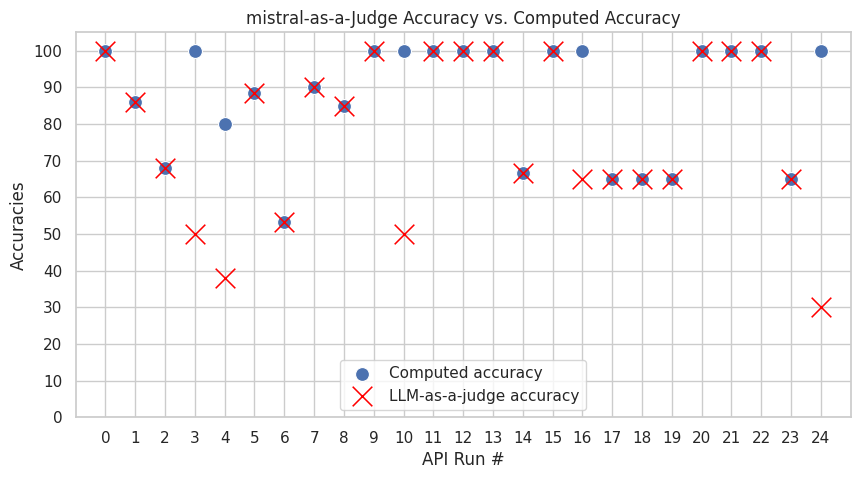

In [23]:
RESULTS_DIR = "results12172024"
mistral_schema_true_df = plot_scores("mistral", True, False)

['76.67', '0', '74', '100', '44', '38.33', '36.67', '76.9', '100', '65', '75', '76.67', '100', '100', '66.7', '66.7', '100', '65', '70', '50', '100', '100', '100', '100', '100']
[76.66666666666667, 72.0, 40.0, 100.0, 72.0, 83.33333333333334, 100.0, 76.66666666666667, 100.0, 100.0, 82.5, 76.66666666666667, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 70.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[1.3661212921142578, 1.9166250228881836, 1.653421401977539, 0.884667158126831, 1.4868202209472656, 1.762237787246704, 4.657472610473633, 2.1232545375823975, 0.794609785079956, 1.815938949584961, 2.2956666946411133, 1.4132494926452637, 1.4639472961425781, 1.619420051574707, 1.8490204811096191, 3.816237211227417, 0.7102909088134766, 1.405022144317627, 1.4297761917114258, 1.5250799655914307, 0.8503882884979248, 0.722022294998169, 0.7007360458374023, 0.8782045841217041, 0.9389300346374512]


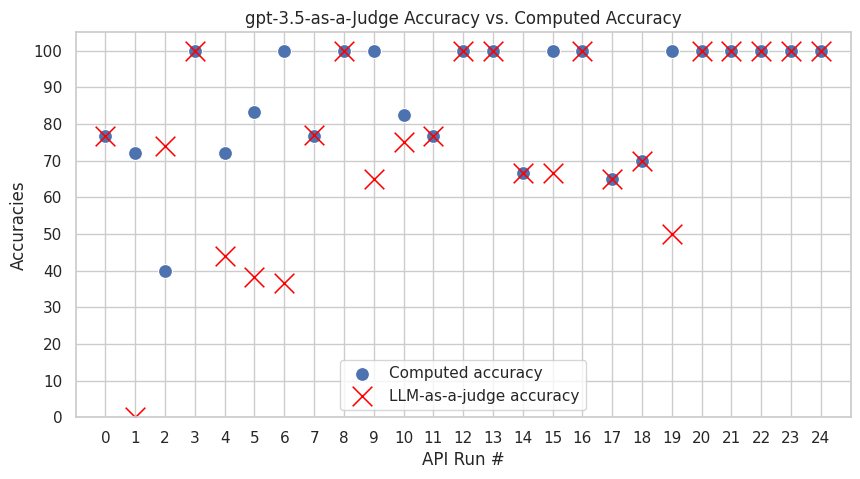

In [25]:
RESULTS_DIR = "results12172024"

gpt3_5_schema_true_df = plot_scores("gpt-3.5", True, False)

['100', '86', '68.0', '100', '80.0', '88.33', '66.67', '90.0', '50.0', '100', '100.0', '100', '76.67', '100', '66.7', '100', '100', '65.0', '65.0', '65.0', '100', '100', '100', '65.0', '0.0']
[100.0, 86.0, 68.0, 100.0, 80.0, 88.33333333333333, 100.0, 90.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 65.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.49387335777282715, 5.125124454498291, 8.175331592559814, 3.7230796813964844, 5.781414031982422, 7.561198949813843, 10.662944078445435, 6.9673309326171875, 5.4196906089782715, 8.593205451965332, 5.084602117538452, 6.466555595397949, 10.201228380203247, 6.902551651000977, 6.872558355331421, 1.5917460918426514, 6.288180589675903, 5.043889045715332, 6.459248065948486, 6.054797172546387, 0.5618493556976318, 0.7699310779571533, 0.5311405658721924, 8.714313745498657, 8.18622636795044]


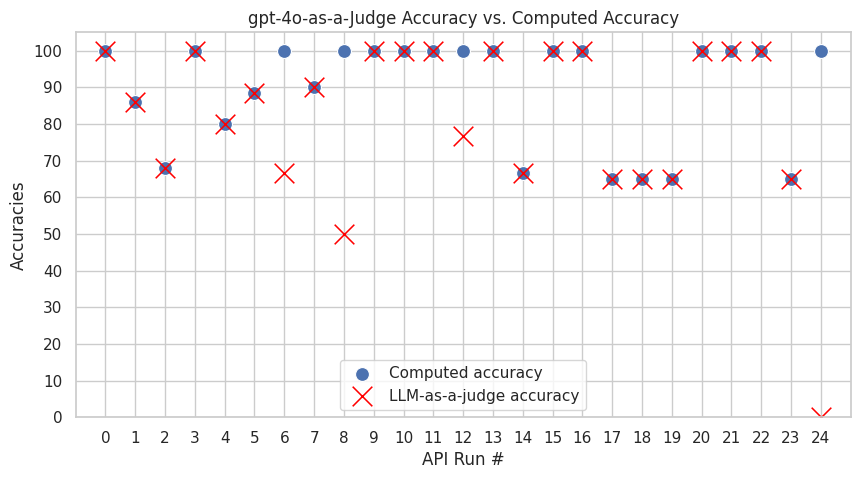

In [26]:
RESULTS_DIR = "results12172024"
gpt4o_schema_true_df = plot_scores("gpt-4o", True, False)

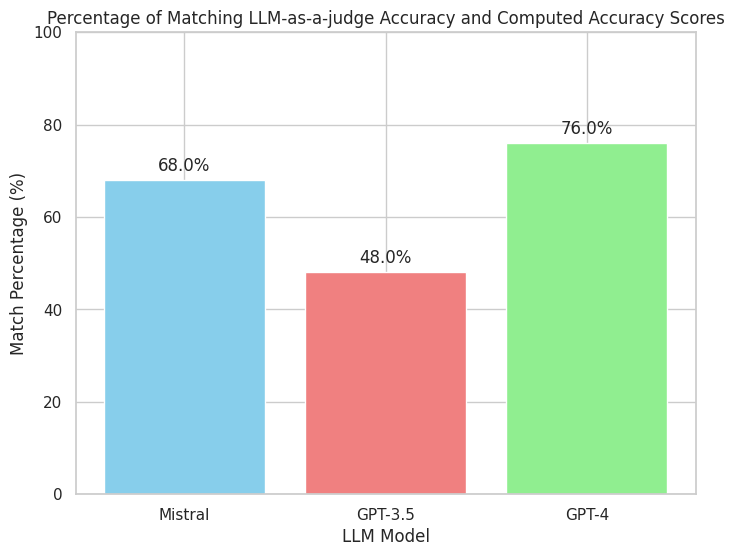

In [67]:
calculate_precent_match(mistral_schema_true_df, gpt3_5_schema_true_df, gpt4o_schema_true_df)

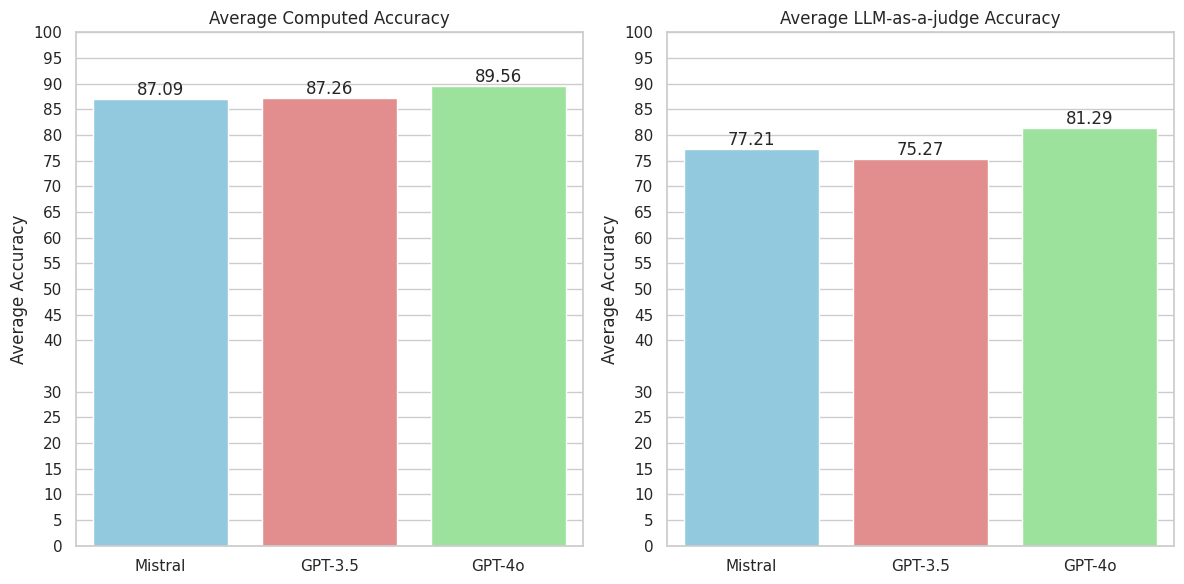

In [27]:
avg_acc_plot(mistral_schema_true_df, gpt3_5_schema_true_df, gpt4o_schema_true_df)

In [114]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/mistral_schema_True_llm_responses.json"

mistral_params_count = get_params_counts(llm_response_file, "mistral")
mistral_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,34,43,36


In [118]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/gpt-3.5_schema_True_llm_responses.json"

gpt3_params_count = get_params_counts(llm_response_file, "gpt-3.5")
gpt3_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,34,43,32


In [117]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/gpt-4o_schema_True_llm_responses.json"

gpt4_params_count = get_params_counts(llm_response_file, "gpt-4o")
gpt4_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,34,43,37


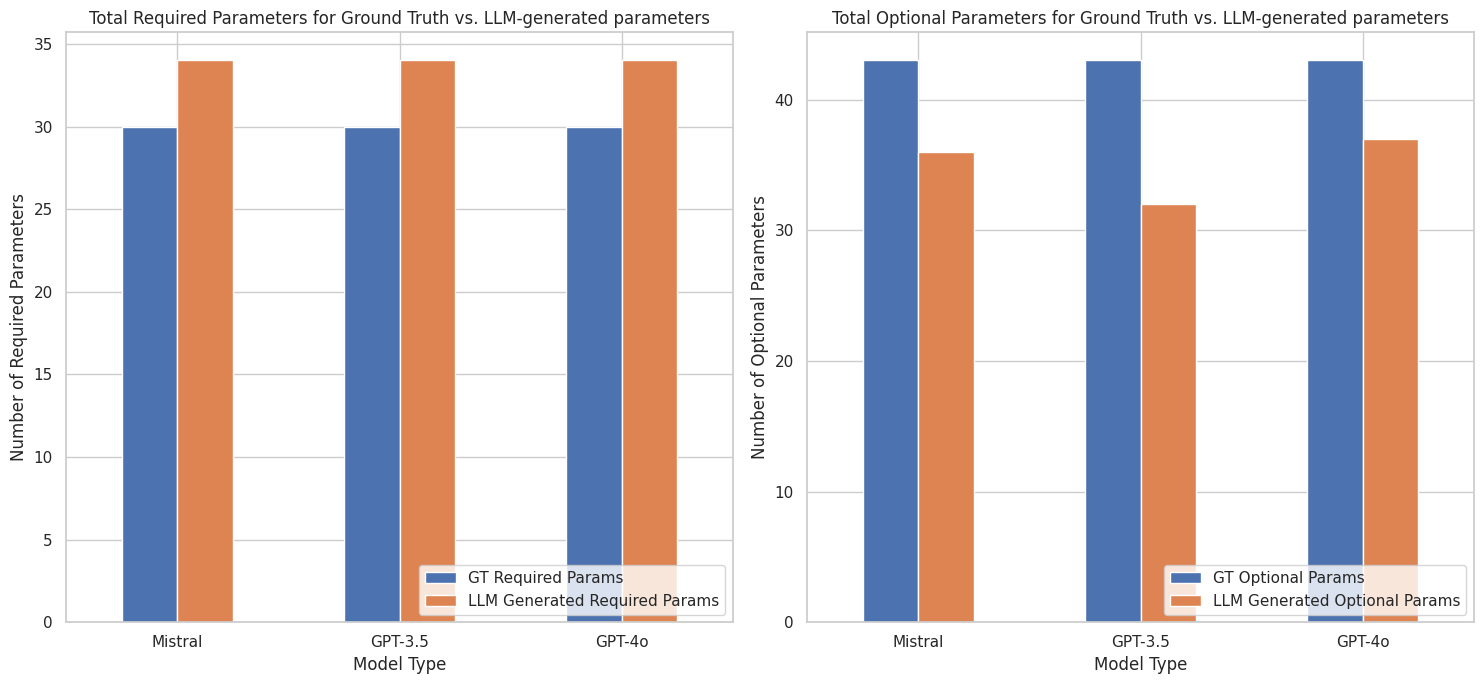

In [176]:
params_count_plot(mistral_params_count, gpt3_params_count, gpt4_params_count)

## With Naive Schema
Below are the plots for LLM-generated results computed using a naive version of the API schema (i.e. LLM has knowledge of parameter names but not whether they are optional or required).


['100', '80.0', '74.0', '50.0', '94.0', '100', '76.67', '90.0', '50.0', '100', '100', '90.0', '100', '100', '66.67', '100', '65.0', '100', '50.0', '65.0', '100', '100', '100', '65.0', '100']
[100.0, 80.0, 34.000000000000014, 100.0, 94.0, 100.0, 76.66666666666667, 90.0, 50.0, 100.0, 100.0, 90.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 100.0, 100.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.692293643951416, 1.2934439182281494, 1.2853751182556152, 0.8682835102081299, 1.4343817234039307, 2.115389347076416, 0.7518606185913086, 1.1459403038024902, 0.9845051765441895, 1.1995031833648682, 1.318422794342041, 1.2652945518493652, 1.125394344329834, 1.1295950412750244, 1.072558879852295, 0.93304443359375, 0.8347854614257812, 1.1865801811218262, 0.93086838722229, 0.7436707019805908, 0.8663997650146484, 0.8321435451507568, 0.978646993637085, 1.570605754852295, 1.1519837379455566]


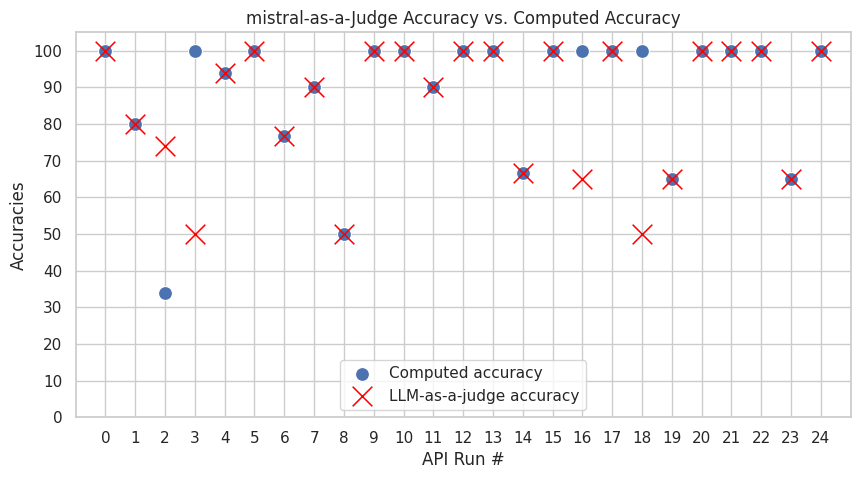

In [28]:
RESULTS_DIR = "results_naive12172024"

mistral_schema_naive_df = plot_scores("mistral", True, True)

['76.9', '94', '48', '85', '86', '33.33', '76.67', '76.9', '50', '100', '82.5', '76.9', '100', '100', '67', '100', '100', '100', '100%', '65', '100', '100', '100', '100', '100']
[76.66666666666667, 94.0, 70.0, 100.0, 86.0, 100.0, 100.0, 76.66666666666667, 50.0, 100.0, 82.5, 76.66666666666667, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.5967414379119873, 0.8249213695526123, 1.203988790512085, 0.5232391357421875, 0.9028103351593018, 0.919175386428833, 0.7564449310302734, 0.7054235935211182, 0.6736721992492676, 0.7706007957458496, 0.8137030601501465, 0.7539613246917725, 1.1628482341766357, 0.80859375, 0.8070371150970459, 0.6502516269683838, 0.7670392990112305, 0.7135958671569824, 0.8657145500183105, 0.6310746669769287, 0.7448394298553467, 0.5586562156677246, 0.6713578701019287, 1.1778512001037598, 0.6766092777252197]


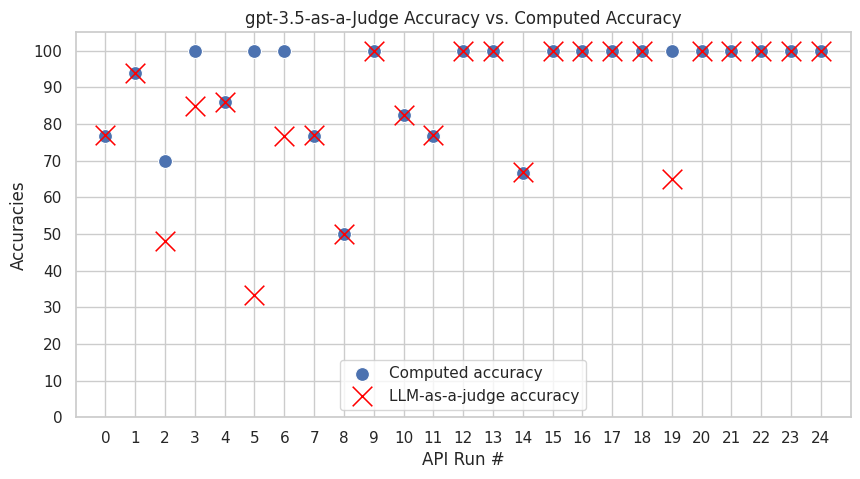

In [29]:
RESULTS_DIR = "results_naive12172024"

gpt3_schema_naive_df = plot_scores("gpt-3.5", True, True)

['100', '80.0', '86.0', '100', '80.0', '53.33', '80.0', '70.0', '65.0', '100', '85.0', '100', '100', '100', '66.67', '100', '100', '100', '65.0', '100', '100', '100', '100', '65.0', '100']
[100.0, 80.0, 86.0, 100.0, 80.0, 88.33333333333333, 100.0, 70.0, 65.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.7708530426025391, 1.0067167282104492, 1.0048727989196777, 0.9711997509002686, 1.3863420486450195, 1.1375963687896729, 1.2515263557434082, 2.175271511077881, 0.5638678073883057, 1.3125455379486084, 1.5649464130401611, 0.8082869052886963, 1.1351706981658936, 1.0760788917541504, 1.1390228271484375, 0.7497899532318115, 1.5991570949554443, 0.8197948932647705, 0.8898868560791016, 1.0693790912628174, 0.6209700107574463, 0.8619956970214844, 0.8659250736236572, 0.8583252429962158, 0.8056900501251221]


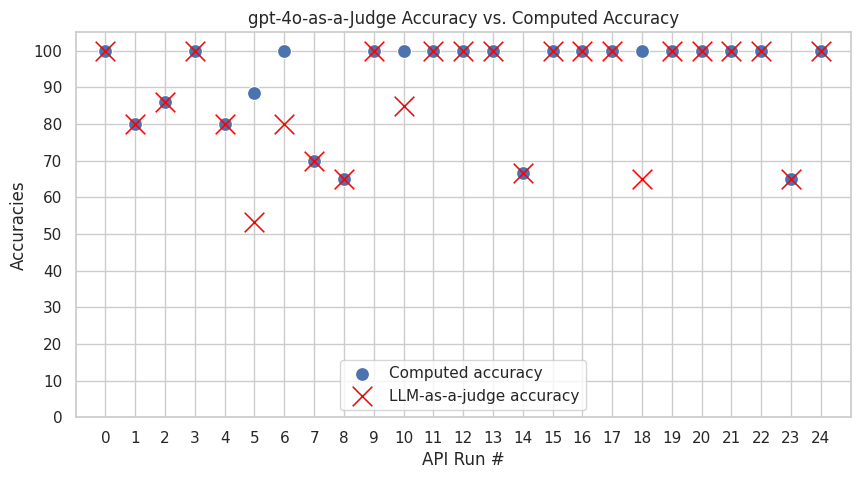

In [30]:
RESULTS_DIR = "results_naive12172024"

gpt4_schema_naive_df = plot_scores("gpt-4o", True, True)

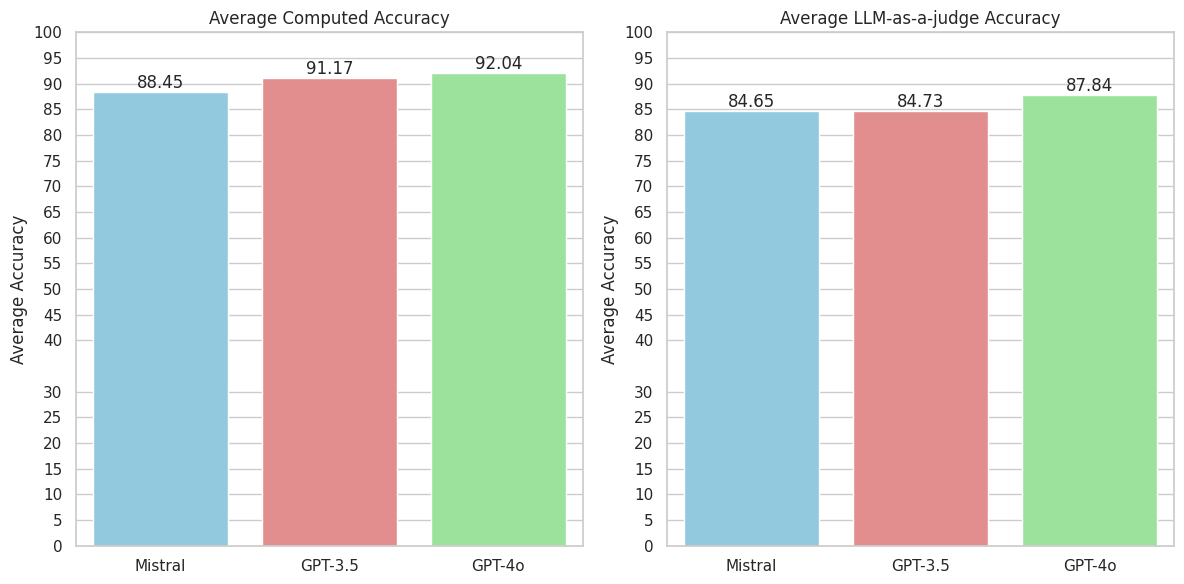

In [31]:
avg_acc_plot(mistral_schema_naive_df, gpt3_schema_naive_df, gpt4_schema_naive_df)

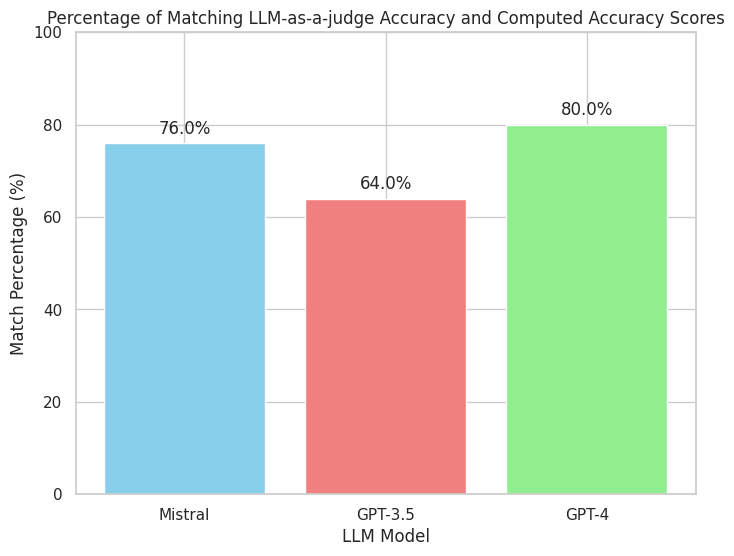

In [233]:
calculate_precent_match(mistral_schema_naive_df, gpt3_schema_naive_df, gpt4_schema_naive_df)

In [237]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results_naive12172024/mistral_schema_True_naive_True_llm_responses.json"

mistral_params_count = get_params_counts(llm_response_file, "mistral")
mistral_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,32,43,43


In [236]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results_naive12172024/gpt-3.5_schema_True_naive_True_llm_responses.json"

gpt3_params_count = get_params_counts(llm_response_file, "gpt-3.5")
gpt3_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,31,43,44


In [238]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results_naive12172024/gpt-4o_schema_True_naive_True_llm_responses.json"

gpt4_params_count = get_params_counts(llm_response_file, "gpt-4o")
gpt4_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,30,43,43


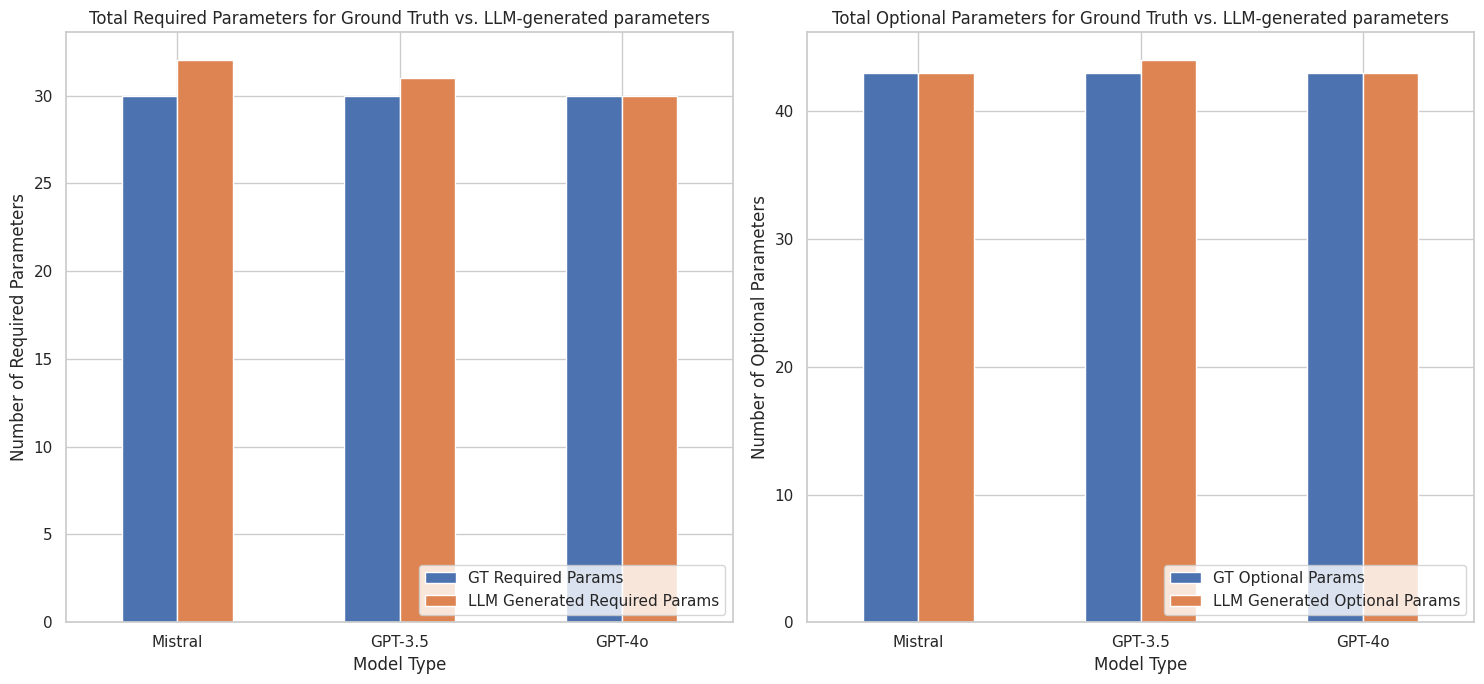

In [239]:
params_count_plot(mistral_params_count, gpt3_params_count, gpt4_params_count)

## Without Spec

Below are the plots for LLM-generated results computed without using any version of the API schema or naive API schema.



['100', '62', '74.0', '100', '86.0', '88.33', '100', '100', '100', '100', '82.5', '70.0', '100', '100', '100', '76.69', '100', '50.0', '50.0', '65.0', '100', '100', '100', '65.0', '100']
[100.0, 14.000000000000014, 34.000000000000014, 50.0, 66.0, 71.66666666666667, 33.33333333333334, 33.33333333333334, 0.0, 0.0, 32.5, -29.99999999999997, 100.0, 66.66666666666667, 100.0, 76.66666666666667, 0.0, 50.0, 50.0, 15.0, 0.0, 0.0, 0.0, 15.0, 0.0]
[0.8249602317810059, 1.4174461364746094, 1.5890448093414307, 0.7419719696044922, 1.3625431060791016, 1.5719218254089355, 0.9721271991729736, 0.838188886642456, 0.7900278568267822, 0.9199697971343994, 0.8153150081634521, 1.2062201499938965, 2.3054802417755127, 1.670513391494751, 1.3855502605438232, 0.6655068397521973, 0.9309585094451904, 1.2152988910675049, 2.142643690109253, 0.9598267078399658, 0.8948726654052734, 1.4055912494659424, 1.1431169509887695, 0.6806683540344238, 0.8722760677337646]


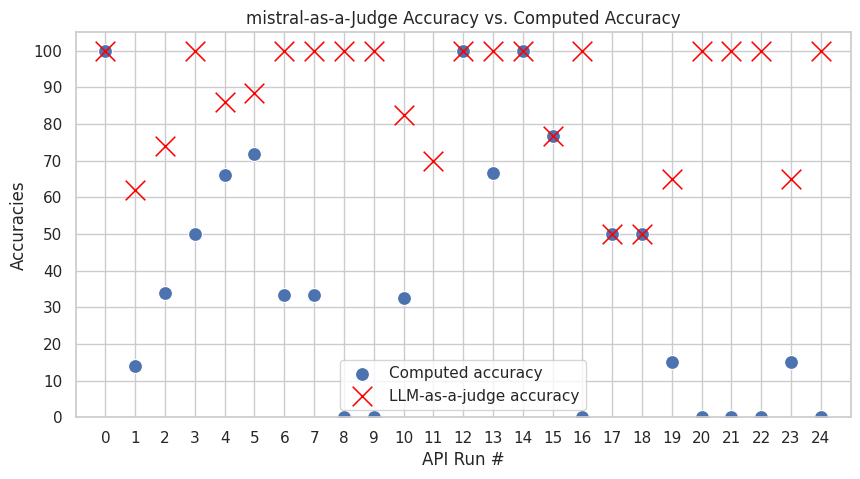

In [35]:
RESULTS_DIR = "results_noschema12172024"

mistral_schema_naive_false_df = plot_scores("mistral", False, False)

['76.9', '20', '46', '65', '72', '55', '100', '43.33', '0', '0', '67.5', '66.67', '100', '100', '76.67', '76.7', '50', '100', '100', '65', '100', '100', '50', '15', '100%']
[76.66666666666667, 14.000000000000014, 6.0, 15.0, 12.000000000000014, 26.666666666666657, 0.0, 13.333333333333343, 0.0, 0.0, 32.5, 10.000000000000014, 66.66666666666667, 100.0, 76.66666666666667, 76.66666666666667, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 15.0, 15.0, 0.0]
[0.7572410106658936, 1.4652352333068848, 0.8172245025634766, 0.7173655033111572, 0.8638255596160889, 0.8684201240539551, 1.262864112854004, 0.8033344745635986, 0.7815310955047607, 0.6467587947845459, 0.7502927780151367, 0.7225058078765869, 0.6841592788696289, 0.7260406017303467, 0.6394064426422119, 0.686107873916626, 0.8262450695037842, 0.6823816299438477, 0.718900203704834, 0.5992372035980225, 0.6428029537200928, 0.6606059074401855, 0.7166540622711182, 0.647740364074707, 0.7024552822113037]


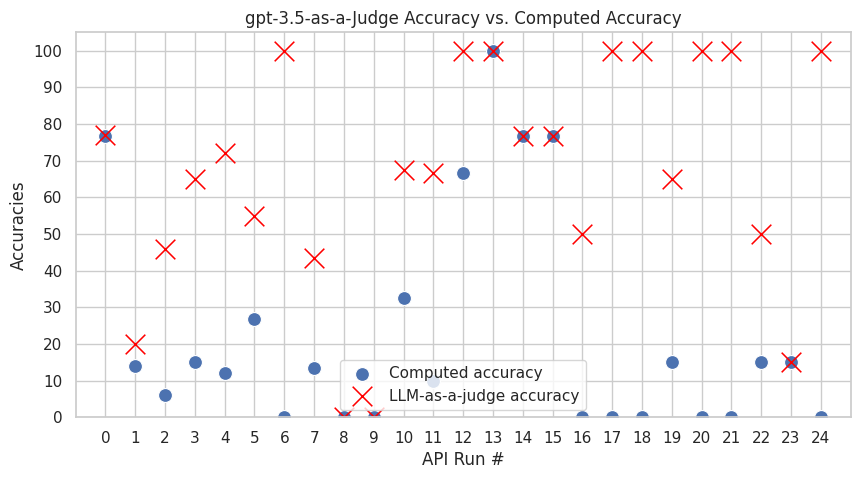

In [36]:
RESULTS_DIR = "results_noschema12172024"

gpt3_schema_naive_false_df = plot_scores("gpt-3.5", False, False)

['100', '74.0', '86.0', '100', '86.0', '48.3', '76.69', '66.7', '65.0', '100', '100', '100', '100', '100', '100', '53.33', '50.0', '65.0', '65.0', '65.0', '100', '100', '65.0', '65.0', '100']
[100.0, 14.000000000000014, 46.0, 0.0, 66.0, 38.33333333333334, 43.333333333333336, 33.33333333333334, 15.0, 0.0, 25.000000000000014, 0.0, 100.0, 66.66666666666667, 100.0, 53.333333333333336, 0.0, 15.0, 15.0, 15.0, 0.0, 0.0, 15.0, 15.0, 0.0]
[2.0485222339630127, 1.372227668762207, 0.8318772315979004, 0.7402212619781494, 2.7615091800689697, 1.2295024394989014, 0.7259526252746582, 0.9488756656646729, 0.6491925716400146, 0.8514566421508789, 1.0630028247833252, 0.902961015701294, 0.7315540313720703, 1.0029091835021973, 1.0739445686340332, 0.833549976348877, 1.2481520175933838, 0.9638917446136475, 0.8633568286895752, 0.9493250846862793, 0.8723134994506836, 0.8130753040313721, 0.7069227695465088, 0.8004100322723389, 1.1313304901123047]


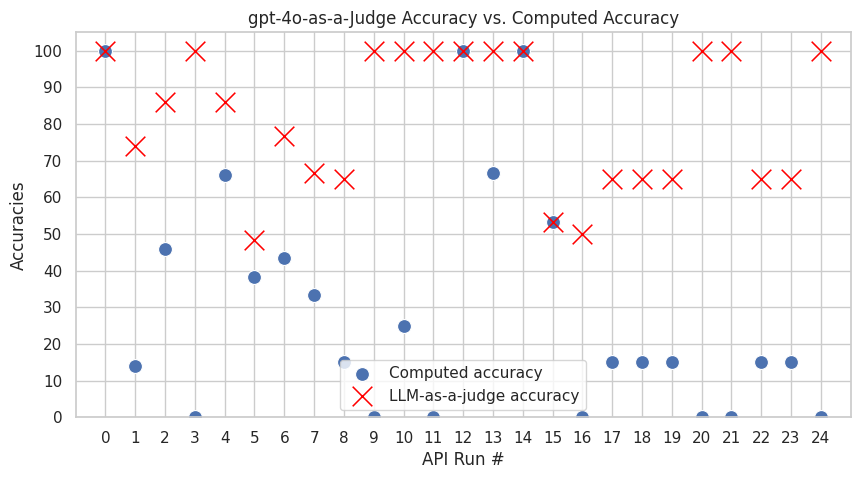

In [37]:
RESULTS_DIR = "results_noschema12172024"

gpt4_schema_naive_false_df = plot_scores("gpt-4o", False, False)

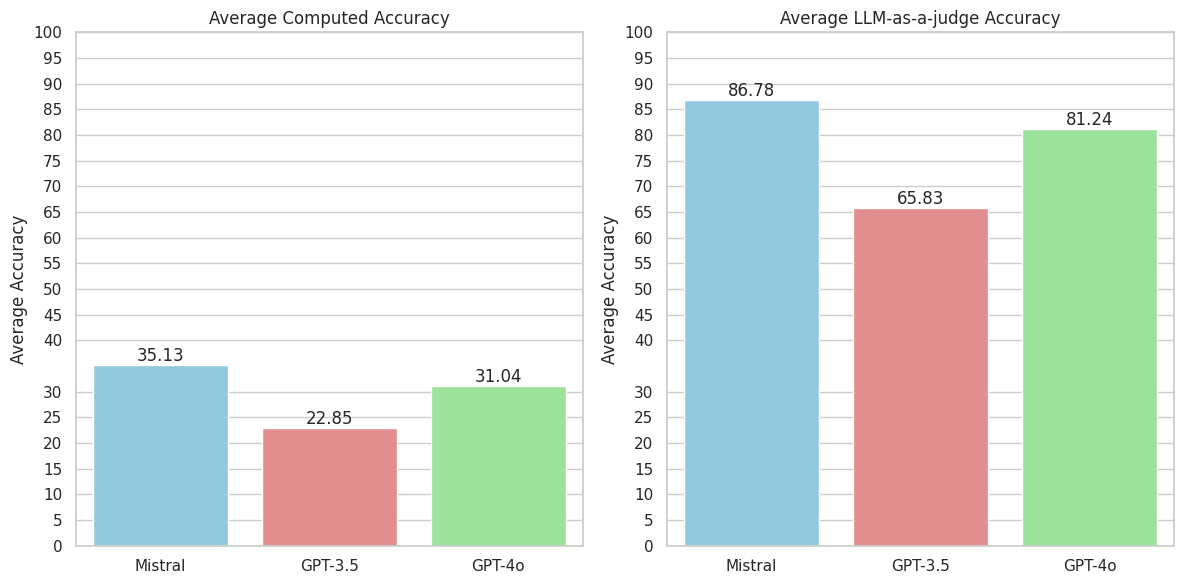

In [38]:
avg_acc_plot(mistral_schema_naive_false_df, gpt3_schema_naive_false_df, gpt4_schema_naive_false_df)

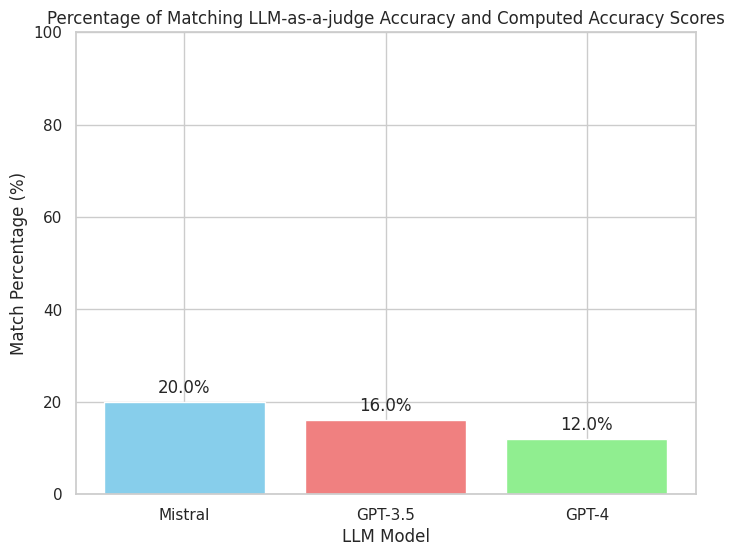

In [39]:
calculate_precent_match(mistral_schema_naive_false_df, gpt3_schema_naive_false_df, gpt4_schema_naive_false_df)

# Earlier Examples


---



## Example 1

In [ ]:
make_api_call({
            "ticker": "msft",
            "formtype": "10-q",
            "filingorder": "10"
        }, "https://last10k-company-v1.p.rapidapi.com/v1/company/balancesheet","last10k-company-v1.p.rapidapi.com")

host  last10k-company-v1.p.rapidapi.com  response code  200


({'meta': {'copyright': 'Copyright 2024 Last10K.com All Rights Reserverd',
   'terms': ['https://dev.last10k.com/terms',
    'https://www.sec.gov/privacy.htm#security']},
  'data': {'attributes': {'status': 0,
    'company': {'name': 'MICROSOFT CORP', 'cik': '789019', 'ticker': 'msft'},
    'filing': {'name': 'Balance Sheets',
     'accessionNumber': '0001564590-21-020891',
     'filingDate': '2021-04-27T00:00:00',
     'period': '2021-03-31T00:00:00',
     'formType': '10-Q',
     'filingCount': 0},
    'count': 33,
    'result': {'CashAndCashEquivalentsAtCarryingValue': 13702000000.0,
     'ShortTermInvestments': 111705000000.0,
     'CashCashEquivalentsAndShortTermInvestments': 125407000000.0,
     'AccountsReceivableNetCurrent': 26322000000.0,
     'InventoryNet': 2245000000.0,
     'OtherAssetsCurrent': 11640000000.0,
     'AssetsCurrent': 165614000000.0,
     'PropertyPlantAndEquipmentNet': 54945000000.0,
     'OperatingLeaseRightOfUseAsset': 10673000000.0,
     'LongTermInvestme

In [ ]:
query_string = {"q":"London","days":"1","aqi":"yes"}
api_url = "https://weatherapi-com.p.rapidapi.com/forecast.json"
host = "weatherapi-com.p.rapidapi.com"

all_weather_params = {
    "q" : "required",
    "days" : "required",
    "hour" : "optional",
    "aqi" : "optional",
    "tp" : "optional",
    "lang" : "optional",
}


In [ ]:
ground_truth_res, ground_truth_params = make_api_call(query_string, api_url, host)

In [ ]:
json_print(ground_truth_res)

{
  "location": {
    "name": "London",
    "region": "City of London, Greater London",
    "country": "United Kingdom",
    "lat": 51.5171,
    "lon": -0.1062,
    "tz_id": "Europe/London",
    "localtime_epoch": 1734077583,
    "localtime": "2024-12-13 08:13"
  },
  "current": {
    "last_updated_epoch": 1734076800,
    "last_updated": "2024-12-13 08:00",
    "temp_c": 6.0,
    "temp_f": 42.8,
    "is_day": 1,
    "condition": {
      "text": "Light rain",
      "icon": "//cdn.weatherapi.com/weather/64x64/day/296.png",
      "code": 1183
    },
    "wind_mph": 3.4,
    "wind_kph": 5.4,
    "wind_degree": 108,
    "wind_dir": "ESE",
    "pressure_mb": 1026.0,
    "pressure_in": 30.3,
    "precip_mm": 0.03,
    "precip_in": 0.0,
    "humidity": 100,
    "cloud": 50,
    "feelslike_c": 5.1,
    "feelslike_f": 41.1,
    "windchill_c": 5.5,
    "windchill_f": 41.9,
    "heatindex_c": 6.4,
    "heatindex_f": 43.5,
    "dewpoint_c": 3.2,
    "dewpoint_f": 37.8,
    "vis_km": 4.5,
    "vis_m

In [ ]:
api_endpoint = "https://weatherapi-com.p.rapidapi.com/forecast.json"
api_query = "What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality"
mistral_generated_response = make_llm_api_call(api_endpoint, api_query, "mistral", {}, "")

DEBUG: ```json
{
  "q": "London",
  "days": "1",
  "aqi": "yes"
}
```
DEBUG: {
  "q": "London",
  "days": "1",
  "aqi": "yes"
}



In [ ]:
mistral_generated_response

{'q': 'London', 'days': '1', 'aqi': 'yes'}

In [ ]:
chatgpt_generated_response = make_llm_api_call(api_endpoint, api_query, "openai", {}, "")

DEBUG: {
    "query": "London",
    "day": "today"
}


In [ ]:
chatgpt_generated_response

'{\n    "query": "London",\n    "day": "today"\n}'

In [ ]:
evaluation_result = evaluate_responses(ground_truth_params, mistral_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The two responses are identical, so the accuracy score is 100%. 
Justification: Both responses have the same query parameters ('q', 'days', 'aqi') with the same values, so the accuracy score is maximum.


In [ ]:
evaluation_result = evaluate_responses(ground_truth_params, chatgpt_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The ground truth response has 3 parameters: 'q', 'days', and 'aqi'.
The generated response has 2 parameters: 'query' and 'day'.

Calculating the accuracy:
- Parameters in ground truth but not in generated response: 1 ('days')
- Parameters in generated response but not in ground truth: 2 ('query', 'day')

Accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (2/3)]]
Accuracy = 100 - [100 * [0.7 * 0.33 + 0.3 * 0.67]]
Accuracy = 100 - [100 * (0.231 + 0.201)]
Accuracy = 100 - [100 * 0.432]
Accuracy = 100 - 43.2
Accuracy = 56.8%

Therefore, the accuracy of the generated response is 56.8%. The generated response is not identical to the ground truth response.


In [ ]:
chatgpt_weather_actual_acc = calculate_accuracy(ground_truth_params, chatgpt_generated_response)
mistral_weather_actual_acc = calculate_accuracy(ground_truth_params, mistral_generated_response)

print("ChatGPT Weather Actual Accuracy:", chatgpt_weather_actual_acc)
print("Mistral Weather Actual Accuracy:", mistral_weather_actual_acc)

ChatGPT Weather Actual Accuracy: 76.0
Mistral Weather Actual Accuracy: 100.0


## Example 2

In [ ]:
query_string = {"fromId":"JFK.AIRPORT","toId":"STO.AIRPORT","departDate":"2024-12-13","adults":"2", "cabinClass": "ECONOMY"}
api_url = "https://booking-com15.p.rapidapi.com/api/v1/flights/searchFlights"
host = "booking-com15.p.rapidapi.com"
all_params = {
    "fromId" : "required",
    "toId" : "required",
    "departDate" : "required",
    "returnDate" : "optional",
    "pageNo" : "optional",
    "adults" : "optional",
    "children" : "optional",
    "sort" : "optional",
    "cabinClass" : "optional",
    "currency_code" : "optional",
}


In [ ]:
flights_resp, flights_true_params = make_api_call(query_string, api_url, host)
json_print(flights_resp)

{
  "status": true,
  "message": "Success",
  "timestamp": 1734079225021,
  "data": {
    "aggregation": {
      "totalCount": 107,
      "filteredTotalCount": 107,
      "stops": [
        {
          "numberOfStops": 1,
          "count": 53,
          "minPrice": {
            "currencyCode": "USD",
            "units": 1547,
            "nanos": 290000000
          },
          "minPriceRound": {
            "currencyCode": "USD",
            "units": 1548,
            "nanos": 0
          }
        },
        {
          "numberOfStops": 2,
          "count": 107,
          "minPrice": {
            "currencyCode": "USD",
            "units": 752,
            "nanos": 380000000
          },
          "minPriceRound": {
            "currencyCode": "USD",
            "units": 753,
            "nanos": 0
          }
        }
      ],
      "airlines": [
        {
          "name": "Icelandair",
          "logoUrl": "https://r-xx.bstatic.com/data/airlines_logo/FI.png",
          "iat

In [ ]:
flights_true_params

{'fromId': 'JFK.AIRPORT',
 'toId': 'STO.AIRPORT',
 'departDate': '2024-12-13',
 'adults': '2',
 'cabinClass': 'ECONOMY'}

In [ ]:
api_query = "I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I"
additional_info = "Note that the airport code for fromId and toId must be in the format <Airport code in caps>.AIRPORT"
mistral_flights_generated_response = make_llm_api_call(api_url, api_query, "mistral", all_params, additional_info)

DEBUG: ```json
{
  "fromId": "NYC.AIRPORT",
  "toId": "STO.AIRPORT",
  "departDate": "2024-08-07",
  "adults": "2",
  "currency_code": "USD"
}
```
DEBUG: {
  "fromId": "NYC.AIRPORT",
  "toId": "STO.AIRPORT",
  "departDate": "2024-08-07",
  "adults": "2",
  "currency_code": "USD"
}



In [ ]:
mistral_flights_generated_response

{'fromId': 'NYC.AIRPORT',
 'toId': 'STO.AIRPORT',
 'departDate': '2024-08-07',
 'adults': '2',
 'currency_code': 'USD'}

In [ ]:
chatgpt_flights_generated_response = make_llm_api_call(api_url, api_query, "openai", all_params, additional_info)

DEBUG: {
    'fromId': 'NYC.AIRPORT',
    'toId': 'STO.AIRPORT',
    'departDate': 'today'
}


In [ ]:
chatgpt_flights_generated_response


"{\n    'fromId': 'NYC.AIRPORT',\n    'toId': 'STO.AIRPORT',\n    'departDate': 'today'\n}"

In [ ]:
evaluation_result = evaluate_responses(flights_true_params, mistral_flights_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: Summary:
The two API query parameters are not identical. The generated response is missing the 'fromId' parameter and has an additional 'currency_code' parameter that is not present in the ground truth response. 

Calculation:
Total parameters in ground truth response: 5
Parameters missing in generated response: 1 (fromId)
Parameters additional in generated response: 1 (currency_code)

Accuracy = 100 - [100 * [0.7 * (1/5) + 0.3 * (1/5)]]
Accuracy = 100 - [100 * (0.7*0.2 + 0.3*0.2)]
Accuracy = 100 - [100 * (0.14 + 0.06)]
Accuracy = 100 - [100 * 0.2]
Accuracy = 100 - 20
Accuracy = 80%

Justification:
The accuracy of the generated response is 80% based on the calculation above. The missing 'fromId' parameter and additional 'currency_code' parameter contribute to the deviation from the ground truth response. Further adjustments may be needed to improve the accuracy of the generated response.


In [ ]:
evaluation_result = evaluate_responses(flights_true_params, chatgpt_flights_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The ground truth response and generated response have the following parameters:

Ground Truth Response:
- fromId: JFK.AIRPORT
- toId: STO.AIRPORT
- departDate: 2024-12-13
- adults: 2
- cabinClass: ECONOMY

Generated Response:
- fromId: NYC.AIRPORT
- toId: STO.AIRPORT
- departDate: today

Based on the comparison, we can see that the generated response is missing the 'adults' and 'cabinClass' parameters from the ground truth response. It also replaced the specific departure date with 'today'.

Calculating the accuracy using the provided formula:
- Parameters in ground truth but not in generated response: 2 (adults, cabinClass)
- Parameters in generated response but not in ground truth: 0
- Total number of parameters in ground truth: 5

Accuracy = 100 - [100 * [0.7 * (2/5) + 0.3 * (0/5)]]
Accuracy = 100 - [100 * (0.4 + 0)]
Accuracy = 100 - 40
Accuracy = 60%

Therefore, the accuracy of the generated response is 60%. The summary score is 60% and the justification is that 

In [ ]:
chat_gpt_flights_actual_acc = calculate_accuracy(flights_true_params, chatgpt_flights_generated_response)
mistral_flights_actual_acc = calculate_accuracy(flights_true_params, mistral_flights_generated_response)

print("ChatGPT Flights Actual Accuracy:", chat_gpt_flights_actual_acc)
print("Mistral Flights Actual Accuracy:", mistral_flights_actual_acc)

ChatGPT Flights Actual Accuracy: 72.0
Mistral Flights Actual Accuracy: 80.0
